In the past, I have both [written](https://austinrochford.com/posts/mab-bias.html) and [spoken](https://austinrochford.com/talks.html#:~:text=Two%20Years%20of%20Bayesian%20Bandits%20for%20E%2DCommerce) about the significant role [multi-armed bandits](https://en.wikipedia.org/wiki/Multi-armed_bandit) have played in my [career](https://monetate.com/).  One significant takeaway from my experience so far is the non-[stationarity](https://en.wikipedia.org/wiki/Stationary_process) inherent in the realy world.  Human behavior, especially online, is constantly shifting and changing in ways that many naive statistical models are not built to handle.  There are, of course, many approaches to modeling non-stationary phenomena.  In this post I will share a lesser-known approach that I have found occasionaly useful; in fact, I have never been able to find solid references for this approach.

## Bayesian Models for Sequential Data

I call this approach "decaying Bayesian updating," as it builds on the notion of sequential Bayesian updates as more data arrives over time, while weighting recent data more strongly than older data.  Bayesian modeling is theoretically well-suited to modeling sequences of data that arrive over time, as the posterior after time $t$ makes a natural prior for the likelihood of the  $(t + 1)$-th observation, whose posterior makes a natural prior for the likelihood of the $(t + 2)$-th observation, and so on.

Throughout most of this post, we will use a simple [beta](https://en.wikipedia.org/wiki/Beta_distribution)-[binomial](https://en.wikipedia.org/wiki/Binomial_distribution) model for the probability of success in independent trials, though we occasionally will work with more general distributions as appropriate.

First we establish some preliminary results in the stationary case where $X_1, X_2, \ldots, X_T \sim \text{Ber}(p)$ are [i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables) [Bernoulli-distributed](https://en.wikipedia.org/wiki/Bernoulli_trial) random variables with probability of success $p$.  Let $\pi_0(p)$ be the prior distribution of $p$ before any data is collected, and $\pi_t(p) = \pi(p\ |\ x_1, x_2, \ldots, x_t)$ be the posterior distribution of $p$ after the first $t$ data points have been collected.  There are two plausible methods for calculating $\pi_T(p)$, the posterior distribution of $p$ after all of the data has been collected.  Throughout we assume a uniform prior distribution $\pi_0(p) = 1$ on $p$ for simplicity.  The following analysis does, however, generalize to other, non-uniform beta-distributed priors.

The first method observes that $\sum_{t = 1}^T X_t \sim \text{Bernoulli}(T, p)$, so by Bayes' theorem

$$
\begin{align}
    \pi_T(p)
        & \propto f\left(\sum_{t = 1}^T x_t\ |\ p\right) \cdot \pi_0(p) \\
        & \propto p^{\sum_{t = 1}^T x_t} \cdot (1 - p)^{T - \sum_{t = 1}^T x_t},
\end{align}
$$

which gives

$$\pi_T(p) \sim \text{Beta}\left(1 + \sum_{t = 1}^T x_t, 1 + T - \sum_{t = 1}^T x_t\right).$$

The second method uses sequential Bayesian updating, noting that the posterior distribution after the first observation is

$$
\begin{align}
    \pi_1(p)
        & \propto f(x_1\ |\ p) \cdot \pi_0(p) \\
        & = p^{x_1} \cdot (1 - p)^{1 - x_1}.
\end{align}
$$

Using this posterior as the prior on the second observation, we get

$$
\begin{align}
    \pi_2(p)
        & \propto f(x_2\ |\ p) \cdot \pi_1(p) \\
        & \propto \left(p^{x_2} \cdot (1 - p)^{1 - x_2}\right) \cdot \left(p^{x_1} \cdot (1 - p)^{1 - x_1}\right) \\
        & = p^{x_1 + x_2} \cdot (1 - p)^{2 - (x_1 + x_2)}.
\end{align}
$$

It is apparent that repeating this process $T - 2$ more times will yield

$$\pi_T(p) \propto p^{\sum_{t = 1}^T x_t} \cdot (1 - p)^{T - \sum_{t = 1}^T x_t},$$

so

$$\pi_T(p) \sim \text{Beta}\left(1 + \sum_{t = 1}^T x_t, 1 + T - \sum_{t = 1}^T x_t\right),$$

exactly as in the first method.

It is good that these two methods agree in this stationary case; waiting for all of the data to arrive and performing one Bayesian update is equivalent to updating intermediate posterior distributions after each data point arrives.  If we were [category theorists](https://en.wikipedia.org/wiki/Category_theory), we might say the following [diagram commutes](https://en.wikipedia.org/wiki/Commutative_diagram).

In [1]:
from IPython.display import IFrame

In [2]:
QUIVER_URL = "https://q.uiver.app/#q=WzAsNixbMCwwLCJcXHBpXzAocCkiXSxbMSwxLCJcXHBpXzEocCkiXSxbMiwxLCJcXHBpXzIocCkiXSxbMywxLCJcXGNkb3RzIl0sWzQsMSwiXFxwaV97VCAtMX0ocCkiXSxbNSwwLCJcXHBpX1QocCkiXSxbMCwxLCJmKHhfMVxcIHxcXCBwKSJdLFsxLDIsImYoeF8yXFwgfFxcIHApIl0sWzIsMywiZih4XzNcXCB8XFwgcCkiXSxbMyw0LCJmKHhfe1QgLSAxfVxcIHxcXCBwKSJdLFs0LDUsImYoeF9UXFwgfFxcIHApIl0sWzAsNSwiZlxcbGVmdChcXHN1bV97dCA9IDF9XlR4X3RcXCB8XFwgcFxccmlnaHQpIiwwLHsiY3VydmUiOi0xfV1d&embed"

In [3]:
IFrame(QUIVER_URL, width=889, height=304)

Throughout this post, we will supplement theoretical analysis with simulations.  First we make the necessary Python imports and do some light configuration.

In [4]:
%matplotlib inline

In [5]:
from warnings import filterwarnings

In [6]:
from matplotlib import pyplot as plt, ticker
import numpy as np
import scipy as sp
import seaborn as sns

In [7]:
filterwarnings("ignore", category=RuntimeWarning)

In [8]:
pct_formatter = ticker.StrMethodFormatter("{x:.0%}")

sns.set(color_codes=True)

In [9]:
SEED = 123456789  # for reprodicibility
rng = np.random.default_rng(SEED)

For now we assume that the probability of success is 30% ($p = 0.3$), and that we will collect $T = 5,000$ samples sequentially.

In [10]:
P = 0.3
T = 5_000

We will conduct 1,001 simulations to understand the avarage behavior in this situation.

In [11]:
N_SIM = 1_001

First we generate the $5,000 \times 1,001$ samples.

In [12]:
x = 1 * (rng.uniform(size=(N_SIM, T)) < P)

Next we calculate and visualize the behavior of the [maximum likelihood estimator](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) for $p$, $\hat{p}$, in these simulations.

In [13]:
t = 1 + np.arange(T)
p_mle = x.cumsum(axis=1) / t

In [14]:
N_PLOT_TRAJECTORY = 10

In [15]:
def scale_y_axis(ref_val, *, mult=0.1, ax=None):
    if ax is None:
        ax = plt.gca()

    ax.set_ylim((1 - mult) * ref_val, (1 + mult) * ref_val)


def make_pct_axis(*, ref_val=None, mult=0.1, ax=None):
    if ax is None:
        ax = plt.gca()

    ax.yaxis.set_major_formatter(pct_formatter)

    if ref_val is not None:
        scale_y_axis(ref_val, mult=mult, ax=ax)

    ax.set_ylabel("$p$")


def make_time_axis(*, t_max=T, ax=None):
    if ax is None:
        ax = plt.gca()

    ax.set_xlim(1, t_max)
    ax.set_xlabel("$t$")

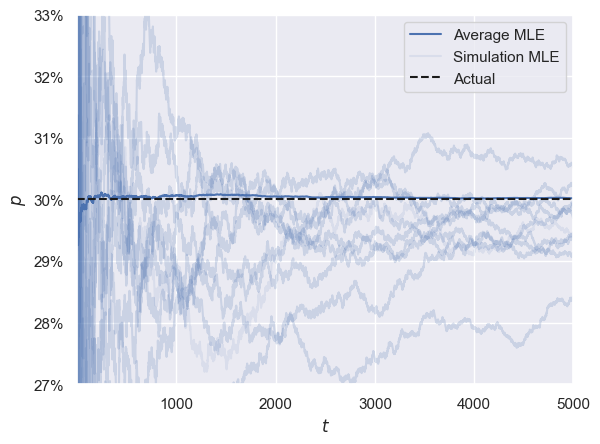

In [16]:
fig, ax = plt.subplots()

ax.plot(t, p_mle.mean(axis=0), label=r"Average MLE")

ax.plot(t, p_mle[0].T, c="C0", alpha=0.1, label=r"Simulation MLE")
ax.plot(t, p_mle[1:N_PLOT_TRAJECTORY].T, c="C0", alpha=0.2)

ax.axhline(P, c="k", ls="--", label="Actual")

make_time_axis(ax=ax)
make_pct_axis(ref_val=P, ax=ax)

ax.legend();

We see that the average value of $\hat{p}$ across simulations is quite close to the actual value of $p = 0.3$, and the sample simulations plotted converge to this true value as $t$ increases.  The former behavior is due to the [law of large numbers](https://en.wikipedia.org/wiki/Law_of_large_numbers), and the rate at which simulations' $\hat{p}$s converge is given by the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem).

Next we calculate the parameters of the posterior distributions at each point in time for each simulation assuming a beta-binomial model with a uniform prior on $p$ at $t = 0$, as above.

In [17]:
α = 1 + x.cumsum(axis=1)
β = 1 + t - x.cumsum(axis=1)

We calculate the posterior expected values of $p$ as well.

In [18]:
def get_bb_post_mean(α, β):
    return α / (α + β)

In [19]:
p_bb = get_bb_post_mean(α, β)

We see that this posterior expected value is quite close to the MLE (on average), especially as $t$ increases.

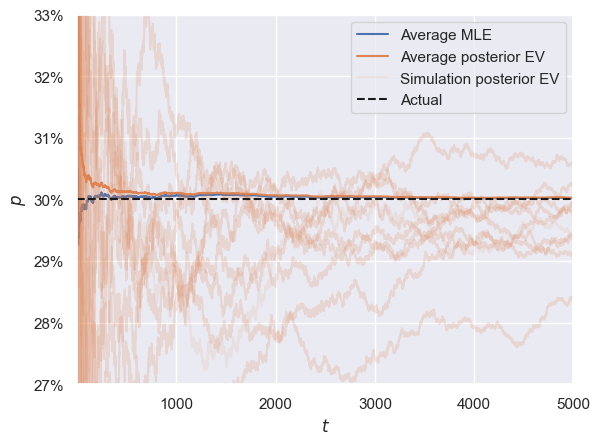

In [20]:
fig, ax = plt.subplots()

ax.plot(t, p_mle.mean(axis=0), label=r"Average MLE")
ax.plot(t, p_bb.mean(axis=0), label=r"Average posterior EV")

ax.plot(t, p_bb[0].T, c="C1", alpha=0.1, label=r"Simulation posterior EV")
ax.plot(t, p_bb[1:N_PLOT_TRAJECTORY].T, c="C1", alpha=0.2)

ax.axhline(P, c="k", ls="--", label="Actual")

make_time_axis(ax=ax)
make_pct_axis(ref_val=P, ax=ax)

ax.legend();

## Decaying Bayesian Updating

To motivate decaying Bayesian updating, we consider what happens to the stationary posterior predictions when the probability of success changes over time.

We will use a simple model where

$$
p_t = \begin{cases}
    0.3 & \text{if } t < T / 2 \\
    0.7 & \text{if } t \geq T / 2
\end{cases}.
$$

First we generate $5,000 \times 1,001$ samples under these assump;tions.

In [21]:
x_ns = 1 * (rng.uniform(size=(N_SIM, T)) < np.where(t < T // 2, P, 1 - P))

Here the suffix `ns` indicates non-stationarity.

We visualize the MLE and posterior expected value in this situation.

In [22]:
p_mle_ns = x_ns.cumsum(axis=1) / t

In [23]:
α_ns = 1 + x_ns.cumsum(axis=1)
β_ns = 1 + t - x_ns.cumsum(axis=1)

p_bb_ns = get_bb_post_mean(α_ns, β_ns)

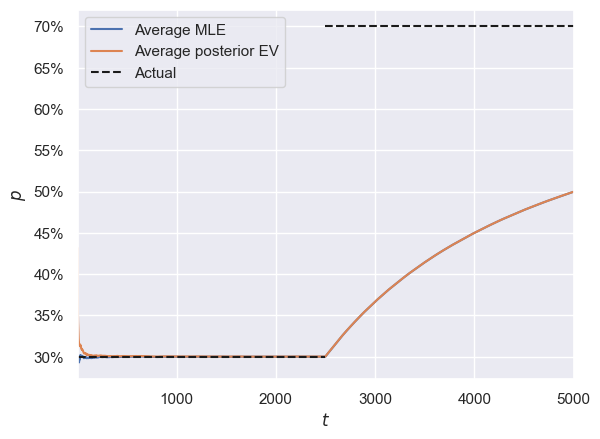

In [24]:
fig, ax = plt.subplots()

ax.plot(t, p_mle_ns.mean(axis=0), label="Average MLE")
ax.plot(t, p_bb_ns.mean(axis=0), label="Average posterior EV")

ax.hlines(P, 1, T // 2, color="k", ls="--", label="Actual")
ax.hlines(1 - P, T // 2, T, color="k", ls="--")

make_time_axis(ax=ax)
make_pct_axis(ax=ax)

ax.legend(loc="upper left");

We see that, though these models are not explicitly built to handle nonstationarity, the estimates do start to move towards the later value of $p$ over time, and would continue to do so if we collected more data.

In some situations, however, we might want the estimates to react more quickly to changes in the success probability over time.  Decaying Bayesian updates give one method to achieve this, though there are many others.  Decaying Bayesian updates can be motivated by writing the standard Bayes' update rule in the somewhat unnatural form

$$
\begin{align}
    \pi_t(\vartheta)
        & \propto f(x_t\ |\ \vartheta) \cdot \pi_{t - 1}(\vartheta) \\
        & = \left(f(x_t\ |\ \vartheta) \cdot \pi_{t - 1}(\vartheta)\right)^{1 - 0} \cdot \pi_0(\vartheta)^0.
\end{align}
$$

$\newcommand{\eps}{\varepsilon}$

The following definition and analysis are not specific to the beta-binomial model we have been discussing so far, so we use $\vartheta$ to denote the set set of parameters of the general model.

If we replace $0$ with a small positive number $0 < \eps \ll 1$, we get the decaying Bayesian update rule

$$\pi_t^{\eps}(\vartheta) = \left(f(x_t\ |\ \vartheta) \cdot \pi_{t - 1}^{\eps}(\vartheta)\right)^{1 - \eps} \cdot \pi_0(\vartheta)^{\eps}.$$

With this definition, we see that the decayed posterior at time $t$, $\pi_t^{\eps}(\vartheta),$ is proportional to the [weighted geometric mean](https://en.wikipedia.org/wiki/Weighted_geometric_mean) of the (almost) usual joint distribution $f(x_t\ |\ \vartheta) \cdot \pi_{t - 1}^{\eps}(\vartheta)$
 with weight $1 - \eps$ and the no data prior $\pi_0(\vartheta)$ with weight $\eps$.

One advantage of this approach over some other methods of accounting for non-stationarity is that, for many model specifications, there is a closed-form, easily computable form for $\pi_t^{\eps}(\vartheta)$.  Throughout the rest of this post, we will frequently transition between probabilities and log-probabilities, depending on which is most convenient for the task at hand.  In log-space proprotionality will mean equality up to an additive constant that does not depend on the argument(s) of the function on the left hand side.

**Theorem**

$$\log \pi_t^{\eps}(\vartheta) \propto \ell_t^{\eps}(\vartheta) + \log \pi_0(\vartheta)$$

where

$$\ell_t^{\eps}(\vartheta) = \sum_{s = 1}^t (1 - \eps)^{t - s + 1} \cdot \log f(x_s\ |\ \vartheta)$$

is a decaying version of the [log likelihood function](https://en.wikipedia.org/wiki/Likelihood_function#Log-likelihood).

**Proof**

For the first two observations we get

$$
\begin{align}
    \log \pi_1^{\varepsilon}(\vartheta)
        & \propto (1 - \eps) \cdot \log f(x_1\ |\ \vartheta) + (1 - \eps) \cdot \log \pi_0(\vartheta) + \eps \cdot \log \pi_0(\vartheta) \\
        & = (1 - \eps) \cdot \log f(x_1\ |\ \vartheta) + \log \pi_0(\vartheta) \\
    \log \pi_2^{\varepsilon}(p)
        & \propto (1 - \eps) \cdot \log f(x_2\ |\ \vartheta) + (1 - \eps) \cdot \log \pi_1^{\eps}(\vartheta) + \eps \cdot \log \pi_0(\vartheta) \\
        & \propto (1 - \eps)^2 \cdot \log f(x_1\ |\ \vartheta) + (1 - \eps) \cdot \log f(x_2\ |\ \vartheta) + \log \pi_0(\vartheta).
\end{align}
$$

The emergence of the form in the theorem for arbitrary time $t$ is clear from here.

**QED**

We see that there is simple, closed-form expression for the contribution of the no data prior to the decayed posterior.  For many common distributions, the decayed log likelihood, $\ell_t^{\varepsilon}(\vartheta)$, will also have a relatively simple form.  We will return to some specific examples of these distributions throughout this post.

Returning to the beta-binomial case, where

$$\log f(x\ |\ p) = x \log p + (1 - x) \cdot \log(1 - p),$$

we have

$$
\begin{align}
    \log \pi_t^{\eps}(p)
        & \propto \ell_t^{\eps}(p) + \log \pi_0(p) \\
        & = \sum_{s = 1}^t (1 - \eps)^{t - s + 1} \cdot \log f(x_s\ |\ p) \\
        & = \left(\sum_{s = 1}^t (1 - \eps)^{t - s + 1} \cdot x_s\right) \cdot \log p + \left(\sum_{s = 1}^t (1 - \eps)^{t - s + 1} \cdot (1 - x_s)\right) \cdot \log (1 - p),
\end{align}
$$

so

$$\pi_t^{\eps}(p) \sim \text{Beta}\left(1 + \sum_{s = 1}^t (1 - \eps)^{t - s + 1} \cdot x_s, 1 + \sum_{s = 1}^t (1 - \eps)^{t - s + 1} \cdot (1 - x_s)\right).$$

In my last [post](https://austinrochford.com/posts/cumsum-matmul.html), I showed how to compute sums of this form via matrix multiplication with an upper triangular matrix.  We now use this method to calcumate the decayed posterior distributions for a variety of values of $0 < \eps \ll 1$.

In [25]:
def get_decay(T, ε):
    return np.triu((1 - ε) ** sp.linalg.toeplitz(1 + np.arange(T)))

In [26]:
def get_bb_decayed_posterior(x, ε, *, α0=1, β0=1):
    _, T = x.shape
    decay = get_decay(T, ε)

    α = α0 + x @ decay
    β = β0 + (1 - x) @ decay

    return α, β

In [27]:
EPSILONS = [0.1, 0.01, 0.001, 0.0001]

bb_decayed_ns = {ε: get_bb_decayed_posterior(x_ns, ε) for ε in EPSILONS}

We now visualize the posterior expected success rates from these decayed models, along with those of the stationary models calculated previously.

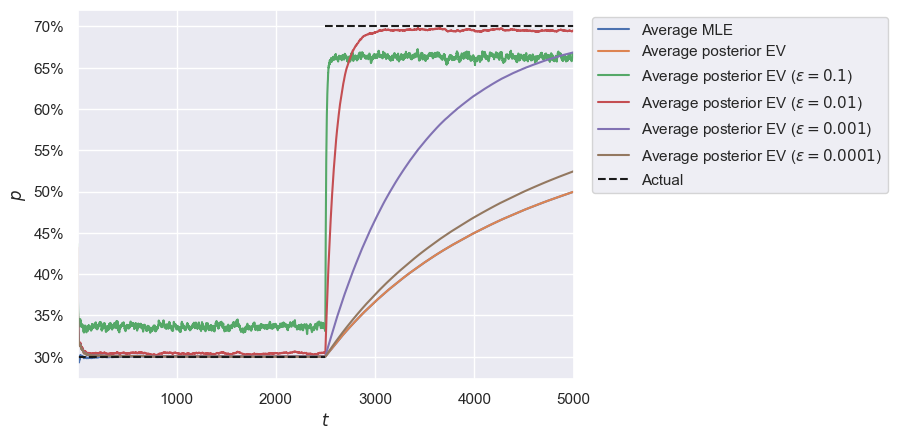

In [28]:
fig, ax = plt.subplots()

ax.plot(t, p_mle_ns.mean(axis=0), label="Average MLE")
ax.plot(t, p_bb_ns.mean(axis=0), label="Average posterior EV")

for ε, (α_decayed_ns, β_decayed_ns) in bb_decayed_ns.items():
    ax.plot(
        t,
        get_bb_post_mean(α_decayed_ns, β_decayed_ns).mean(axis=0),
        label=f"Average posterior EV ($\\varepsilon = {ε}$)",
    )

ax.hlines(P, 1, T // 2, color="k", ls="--", label="Actual")
ax.hlines(1 - P, T // 2, T, color="k", ls="--")

make_time_axis(ax=ax)
make_pct_axis(ax=ax)

ax.legend(loc="upper right", bbox_to_anchor=(1.65, 1));

We see that the decayed models are significantly more responsive to the nonstationarity of the success probability, with exactly how responsive they are depending on the value of $\eps$.

Inuitively, we expect larger values of $\eps$ to lead to faster decay, and therefore faster reactions to changes in the success probability.  We do see exactly that in this plot, but there is some nuance.  The $\eps = 0.1$ model does indeed react the fastest to the change in success probability, but during the stationary periods, that models does not capture the true sucesss probability well.

### Effective sample size

This observation leads us to consider the effective sample size of each model.  One interpretation of decayed updates is that they reduce the model's effective sample size by a factor controlled by $\eps$ when compared to a stationary model, so that when the true distribution shifts, they have less sample size inertia to overcome when adapting to the change.

We first quantify this phenomenon for the example beta-binomial models we have been working with.  In the stationary beta-binomial model, we showed above that $\pi_t(p) \sim \text{Beta}(\alpha_t, \beta_t),$ where

$$
\begin{align}
    \alpha_t
        & = 1 + \sum_{s = 1}^t x_s \text{ and} \\
    \beta_t
        & = 1 + t - \sum_{ts= 1}^t x_s.
\end{align}
$$

We can recover the sample size, $t$, of this model from these parameters by noting that

$$t = \alpha_t + \beta_t - 2.$$

This expression for $t$ motivates the following definition for the effective samples size of a decayed model.  If $\pi_t^{\eps}(p) \sim
\text{Beta}(\alpha_t^{\eps}, \beta_t^{\eps}),$ we let

$$n_{\text{eff}, t}^{\eps} = \alpha_t^{\eps} + \beta_t^{\eps} - 2$$

be the effective sample size of the model.

We can simplify this expression to

$$
\begin{align}
    n_{\text{eff}, t}^{\eps}
        & = \alpha_t^{\eps} + \beta_t^{\eps} - 2 \\
        & = \sum_{s = 1}^t (1 - \eps)^{t - s + 1} \\
        & = (1 - \eps)^{t + 1} \cdot \left(\frac{1 - (1 - \eps)^{-(t + 1)}}{1 - (1 - \eps)^{-1}} - 1\right) \\
        & = \frac{1 - (1 - \eps)^t}{(1 - \eps)^{-1} - 1} \\
        & = \frac{1 - \eps}{\eps} \cdot \left(1 - (1 - \eps)^t\right).
\end{align}
$$

The following plots show both ways of calculating this effective sample size, confirming our simplification is correct.

In [29]:
def get_ess(t, ε):
    return (1 - ε) / ε * (1 - (1 - ε) ** t)

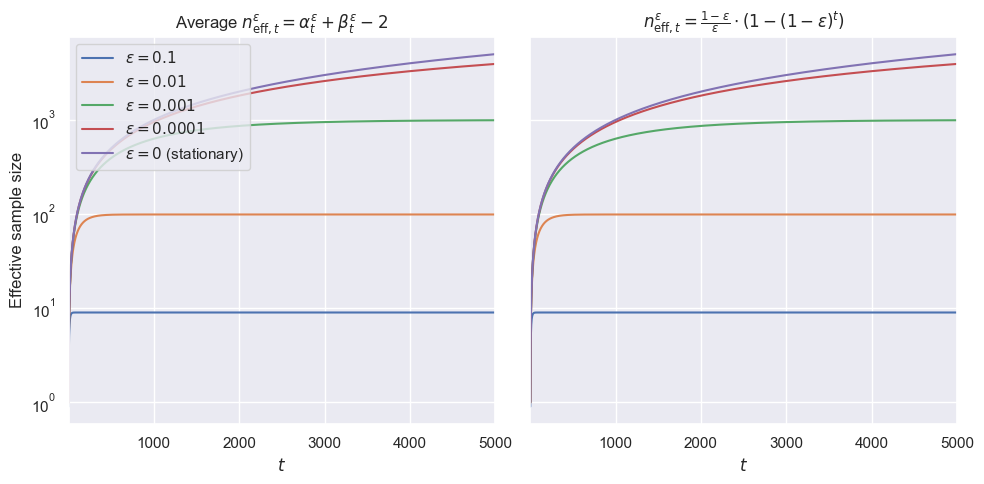

In [30]:
fig, (stat_ax, form_ax) = plt.subplots(
    figsize=(10, 5), ncols=2, sharex=True, sharey=True
)

for ε, (α_decayed, β_decayed) in bb_decayed_ns.items():
    stat_ax.plot(
        t, (α_decayed + β_decayed).mean(axis=0) - 2, label=f"$\\varepsilon = {ε}$"
    )
    form_ax.plot(t, get_ess(t, ε))

stat_ax.plot(t, t, label=r"$\varepsilon = 0$ (stationary)")
form_ax.plot(t, t)

make_time_axis(ax=stat_ax)

stat_ax.set_yscale("log")
stat_ax.set_ylabel("Effective sample size")

stat_ax.set_title(
    r"Average $n_{\text{eff}, t}^{\varepsilon} = \alpha_t^{\varepsilon} + \beta_t^{\varepsilon} - 2$"
)
stat_ax.legend(loc="upper left")

make_time_axis(ax=form_ax)
form_ax.set_title(
    r"$n_{\text{eff}, t}^{\varepsilon} = \frac{1 - \varepsilon}{\varepsilon} \cdot (1 - (1 - \varepsilon)^t)$"
)

fig.tight_layout();

The most striking feature of these plots is that the decayed models have an asymptotic maximum sample size.  In fact,

$$n_{\text{eff}, \infty}^\eps = \lim_{t \to \infty} n_{\text{eff}, t}^{\eps} = \frac{1 - \eps}{\eps},$$

so we see that a choice of $0 < \eps \ll 1$ is equivalent to choosing an asymptotic maximum sample size.  This relationship between these quantities is visualized below.

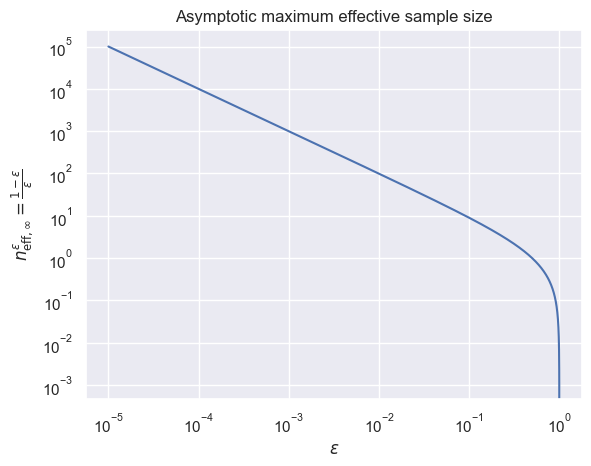

In [31]:
fig, ax = plt.subplots()

plot_ε = np.logspace(-5, 0, 10_000)

ax.plot(plot_ε, (1 - plot_ε) / plot_ε)

ax.set_xscale("log")
ax.set_xlabel(r"$\varepsilon$")

ax.set_yscale("log")
ax.set_ylabel(
    r"$n_{\text{eff}, \infty}^{\varepsilon} = \frac{1 - \varepsilon}{\varepsilon}$"
)

ax.set_title("Asymptotic maximum effective sample size");

So far we have not addressed methods for choosing the decay parameter, $\eps$, but this analysis of asymptotic maximum effective sample size provides some intuition.  If we have an intuition for the rough time scale (in terms of number of samples) over which we expect the parameters of interest to meaningfully vary, we can choose $\eps$ to produce the corresponding asymptotic maximum effective sample size.  We will discuss another perspective on choosing $\eps$ later in this post.

So far our analysis of effective sample size has been theoretical.  We now turn to the practical implications of reduced effective sample size.  When our (effective) sample size is relatively smaller, we expect more uncertainy in our estimates, corresponding to relatively larger credible intervals.  We return to the stationary case to visualize this behavior.

In [32]:
bb_decayed = {ε: get_bb_decayed_posterior(x, ε) for ε in EPSILONS}

In [33]:
CI_WIDTH = 0.95

In [34]:
def get_bb_ci_width(α, β):
    dist = sp.stats.beta(α, β)

    low = dist.ppf((1 - CI_WIDTH) / 2)
    high = dist.isf((1 - CI_WIDTH) / 2)

    return high - low

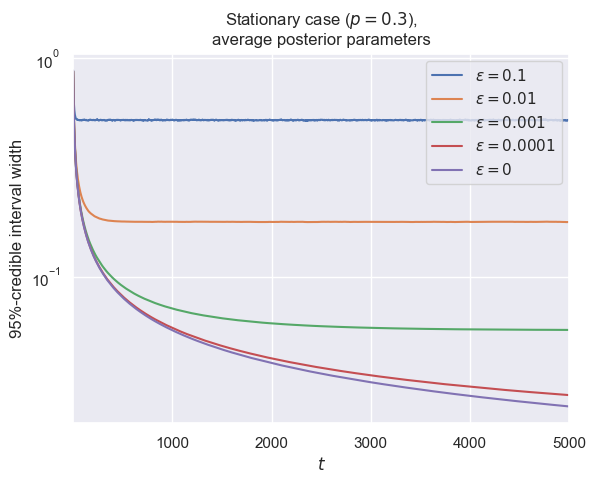

In [35]:
fig, ax = plt.subplots()

for ε, (α_decayed, β_decayed) in bb_decayed.items():
    ax.plot(
        t,
        get_bb_ci_width(α_decayed.mean(axis=0), β_decayed.mean(axis=0)),
        label=f"$\\varepsilon = {ε}$",
    )

ax.plot(t, get_bb_ci_width(α.mean(axis=0), β.mean(axis=0)), label=r"$\varepsilon = 0$")

make_time_axis(ax=ax)

ax.set_yscale("log")
ax.set_ylabel(f"{CI_WIDTH:.0%}-credible interval width")

ax.legend()
ax.set_title(f"Stationary case ($p = {P:0.1f}$),\naverage posterior parameters");

This plot confirms that as $\eps$ increases and the effective sample size decreases, the width of the credible interval increases.  This relationship makes clear a fundamental tradeoff at the heart of model decay; to increase the speed at which the models react to changes in the true parameters, we are introducing uncertainty that makes them less confident in the stationary case.

### No data updates, sample time versus clock time

Throughout this post so far, we have been implicitly defining the progression of time by the arrival of another piece of data.  That is, if we have collected samples $x_1, x_2, \ldots, x_t$, we say that we have reached time $t + 1$ when the next piece of data, $x_{t + 1}$ arrives.  We call this definition of time _sample time_.  Depending on the data generating process, the clock time between sample times $t$ and $t + 1$ may be constant or could vary.

While this sample time approach is convenient in many cases, others call for defining the the progression of time independently of data arrival.  For simplicity, we will assume data arrives (or not, more about that shortly) at even spaced intervals according to the progression of _clock time_.  If we are guaranteed to have data arrive at even clock time intervals, there is no real difference between samplem time and clock time as we have described them here.  It is when data is not guaranteed to arrive at every clock time interval that the difference between these definitions becomes interesting.  This sort of situation arrives, for instance, when we are updating models on a regular interval based on visits to certain parts of a website.  If the update interval is short (single digit minutes), some portions of a website may not get visited during every time interval.

Assume we are operating by clock time.  If no data arrives between time $t$ and $t+1$, we define the decayed posterior at time $t + 1$ as

$$\pi_{t + 1}^{\eps}(\vartheta) \propto \pi_t^{\eps}(\vartheta)^{1 - \eps} \cdot \pi_0(\vartheta)^{\eps}.$$

Note that this is equivalent to assuming the likelihood of no data is one, together with the standard definition of the decayed posterior.  Intuitively, when no data arrives, we shrink the posterior back towards the $t = 0$ prior.

Returning to the beta-binomial model for simplicity, assume that at time $t$, $\pi_t^{\eps}(p) \sim \text{Beta}(\alpha_t, \beta_t).$  Assume that no data arrives after time $t$.  We will now explore the behavior of the decayed posterior as time goes on.

At time $t + 1$,

$$
\begin{align}
    \log \pi_{t + 1}^{\eps}(p)
        & \propto (1 - \eps) \cdot \log \pi_t^{\eps}(p) + \eps \cdot \log \pi_0(p) \\
        & \propto (1 - \eps) \cdot \left((\alpha_t - 1) \cdot \log p + (\beta_t - 1) \cdot \log(1 - p)\right) \\
        & = (1 - \eps) \cdot (\alpha_t - 1) \cdot \log p + (1 - \eps) \cdot (\beta_t - 1) \cdot \log(1 - p).
\end{align}
$$

At time $t + 2$,

$$
\begin{align}
    \log \pi_{t + 2}^{\eps}(p)
        & \propto (1 - \eps) \cdot \log \pi_{t + 1}^{\eps}(p) + \eps \cdot \log \pi_0(p) \\
        & \propto (1 - \eps)^2 \cdot (\alpha_t - 1) \cdot \log p + (1 - \eps)^2 \cdot (\beta_t - 1) \cdot \log(1 - p).
\end{align}
$$

The pattern is apparent, so at time $t + s$, we have

$$\log \pi_{t + s}^{\eps}(p) \propto (1 - \eps)^s \cdot (\alpha_t - 1) \cdot \log p + (1 - \eps)^s \cdot (\beta_t - 1) \cdot \log(1 - p),$$

so

$$\pi_{t + s}^{\eps}(p) \sim \text{Beta}\left(1 + (1 - \eps)^s \cdot (\alpha_t - 1), 1 + (1 - \eps)^s \cdot (\beta_t - 1)\right).$$

We see that

$$\lim_{s \to \infty} \pi_{t + s}^{\eps}(p) \sim \text{Beta}(1, 1) = \pi_0(p),$$

so as longer periods of time go without any data arriving, the decayed posterior approaches the $t = 0$ posterior.

Calculating the effective sample size at time $t + s$ we get

$$
\begin{align}
    n_{\text{eff}, t + s}^{\eps}
        & = (1 - \eps)^s \cdot (\alpha_t + \beta_t - 2).
\end{align}
$$

We can get another heuristic for helping to choose $\eps$ by calculating the half-life of information, which is how long it takes the effective sample size to be cut in half after an extended period of no data. We get

$$
\begin{align}
    n_{\text{eff}, t_{1/2}^{\eps}}^{\eps}
        & = \frac{1}{2} n_{\text{eff}, t}^{\eps} \\
    (1 - \eps)^{t_{1/2}^{\eps}} \cdot (\alpha_t + \beta_t - 2)
        & = \frac{1}{2} \cdot (\alpha_t + \beta_t - 2) \\
    t_{1/2}^{\eps}
        & = -\frac{\log 2}{\log(1 - \eps)}.
\end{align}
$$

We visualize how thisn quantity changes with $\eps$ below.

In [36]:
def get_bb_half_life(ε):
    return -np.log(2) / np.log(1 - ε)

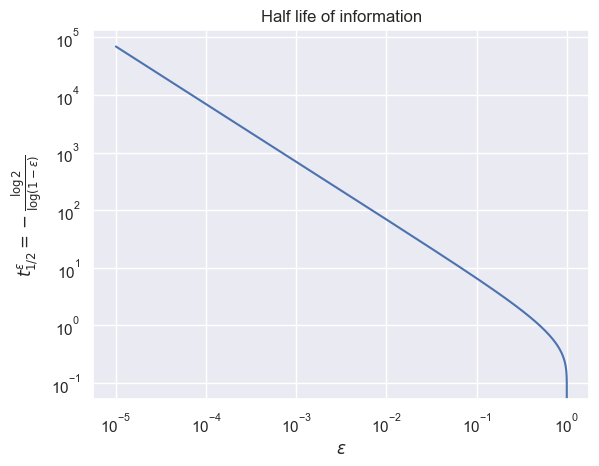

In [37]:
fig, ax = plt.subplots()

ax.plot(plot_ε, get_bb_half_life(plot_ε))

ax.set_xscale("log")
ax.set_xlabel(r"$\varepsilon$")

ax.set_yscale("log")
ax.set_ylabel(r"$t_{1/2}^{\varepsilon} = -\frac{\log 2}{\log(1 - \varepsilon)}$")

ax.set_title("Half life of information");

There may be some situations where we have stronger intuition around the half life of information than the time scale over which we expect changes to occur.  In this case the above quantity may be used to choose an appropriate value of $\eps$.

### Decayed posteriors for exponential family distributions

So far we have focused our concrete analysis of decayed Bayesian updated on the simple beta-binomial model.  Analogous closed-form expressions exist for the decayed posterior many different distributions.  In this section, we will show that this is the case for distributions in the [exponential family](https://en.wikipedia.org/wiki/Exponential_family), a class which includes many common distributions (normal, exponential, $\chi^2$, etc.).

Recall that a distribution is in the exponential family if its probability density function is of the form

$$f(x\ |\ \eta) \propto \exp(\eta \cdot T(x) - A(\eta)),$$

where $T$ is a [sufficient statistic](https://en.wikipedia.org/wiki/Sufficient_statistic) of the distribution and $A$ is its [log-partition function](https://en.wikipedia.org/wiki/Partition_function_(mathematics)).

A pleasant property of exponential family distributions for Bayesian statistics is that they have conjugate priors given by

$$\pi(\eta\ |\ \chi, \nu) \propto  \exp(\eta \cdot \chi - \nu \cdot A(\eta)).$$

We can quickly verify that the posterior for observation $x$ is

$$
\begin{align}
    \pi(\eta\ |\ x, \chi, \nu)
        & \propto f(x\ |\ \eta) \cdot \pi(\eta\ |\ \chi, \nu) \\
        & \propto \exp(\eta \cdot T(x) - A(\eta)) \cdot \exp(\eta \cdot \chi - \nu \cdot A(\eta)) \\
        & = \exp(\eta \cdot (\chi + T(x)) - (\nu + 1) \cdot A(\eta)),
\end{align}$$

so $\pi(\eta\ |\ x, \chi, \nu) = \pi(\eta\ |\ \chi + T(x), \nu + 1),$ and therefore the prior is conjugate.

**Theorem**

For a distribution in the exponential family with sufficient statistic $T(x)$, log-partition function $A(\eta)$, and conjugate prior $\pi(\eta\ |\ \chi_0, \nu_0)$,

$$\pi_t^{\varepsilon}(\eta\ |\ \chi, \nu) = \pi(\eta\ |\ \chi_t^{\varepsilon}, \nu_t^{\varepsilon}),$$

where

$$\chi_t^{\varepsilon} = \chi_0 + \sum_{s = 1}^t (1 - \varepsilon)^{t - s + 1} \cdot T(x_s),$$

and

$$\nu_t^{\varepsilon} = \nu_0 + \frac{1 - \eps}{\eps} \cdot \left(1 - (1 - \eps)^t\right).$$

**Proof**

Recall from our first theorem that

$$
\begin{align}
    \log \pi_t^{\eps}(\eta)
        & \propto \sum_{s = 1}^t (1 - \eps)^{t - s + 1} \cdot \log f(x_s\ |\ \vartheta) + \log \pi(\eta\ |\ \chi_0, \eta_0) \\
        & \propto \sum_{s = 1}^t (1 - \eps)^{t - s + 1} \cdot (\eta \cdot T(x_s) - A(\eta)) + (\eta \cdot \chi_0 - \nu_0 \cdot A(\eta)) \\
        & = \eta \cdot\left(\chi_0 + \sum_{s = 1}^t (1 - \eps)^{t - s + 1} \cdot T(x_s)\right) + \left(\nu_0 + \sum_{s = 1}^t (1 - \eps)^{t - s + 1}\right) \cdot A(\eta) \\
        & = \eta \cdot \chi_t^{\varepsilon} - \left(\nu_0 + \sum_{s = 1}^t (1 - \eps)^{t - s + 1}\right) \cdot A(\eta).
\end{align}        
$$

We already summed the geometric series present here during our derivation of effective sample size for the beta-binomial model, so we have that

$$
\begin{align}
    \nu_t^{\varepsilon}
        & = \nu_0 + \sum_{s = 1}^t (1 - \eps)^{t - s + 1} \\
        & = \nu_0 + \frac{1 - \eps}{\eps} \cdot \left(1 - (1 - \eps)^t\right).
\end{align}
$$

**QED**

Many of the other calculations we performed for the beta-binomial model above can also be worked out for arbitrary distributions in the exponential family.

This post is available as a Jupyter notebooks [here](https://nbviewer.org/gist/AustinRochford/b082031e074c3c6ffd26e28b47a83fbc).

In [38]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Sat Jan 10 2026

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.29.0

matplotlib: 3.9.2
seaborn   : 0.13.2
numpy     : 2.0.2
IPython   : 8.29.0
scipy     : 1.14.1

